In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)
from matplotlib import rcParams
rcParams['font.family'] = 'Noto Sans CJK JP'
%matplotlib inline

In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_df.head(1)

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,8033256,中古マンション等,NaN,8203,茨城県,土浦市,川口,土浦,11,４ＬＤＫ,75,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第２種住居地域,60.0,200.0,2009年第４四半期,未改装,NaN,7.255273


In [5]:
train_df.isnull().sum()

ID                   0
種類                   0
地域              662799
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                658
最寄駅：名称            2650
最寄駅：距離（分）        23076
間取り              22954
面積（㎡）                0
土地の形状           662799
間口              662799
延床面積（㎡）         662799
建築年              19127
建物の構造            15595
用途               53943
今後の利用目的         363472
前面道路：方位         662799
前面道路：種類         662799
前面道路：幅員（ｍ）      662799
都市計画             18997
建ぺい率（％）          23050
容積率（％）           23050
取引時点                 0
改装               60076
取引の事情等          644339
取引価格（総額）_log         0
dtype: int64

<AxesSubplot:xlabel='取引価格（総額）_log'>

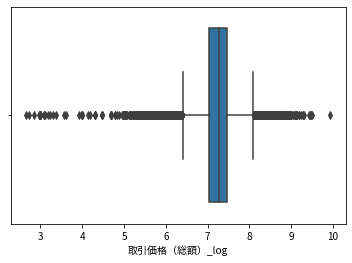

In [6]:
sns.boxplot(x=train_df["取引価格（総額）_log"])

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662799 entries, 0 to 662798
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            662799 non-null  int64  
 1   種類            662799 non-null  object 
 2   地域            0 non-null       float64
 3   市区町村コード       662799 non-null  int64  
 4   都道府県名         662799 non-null  object 
 5   市区町村名         662799 non-null  object 
 6   地区名           662141 non-null  object 
 7   最寄駅：名称        660149 non-null  object 
 8   最寄駅：距離（分）     639723 non-null  object 
 9   間取り           639845 non-null  object 
 10  面積（㎡）         662799 non-null  object 
 11  土地の形状         0 non-null       float64
 12  間口            0 non-null       float64
 13  延床面積（㎡）       0 non-null       float64
 14  建築年           643672 non-null  object 
 15  建物の構造         647204 non-null  object 
 16  用途            608856 non-null  object 
 17  今後の利用目的       299327 non-null  object 
 18  前面道路

In [8]:
train_df.head()

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,8033256,中古マンション等,NaN,8203,茨城県,土浦市,川口,土浦,11,４ＬＤＫ,75,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第２種住居地域,60.0,200.0,2009年第４四半期,未改装,NaN,7.255273
1,8041376,中古マンション等,NaN,8220,茨城県,つくば市,並木,つくば,30分?60分,３ＬＤＫ,80,NaN,NaN,NaN,平成20年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,2010年第３四半期,改装済,NaN,7.278754
2,8003595,中古マンション等,NaN,8201,茨城県,水戸市,南町,水戸,13,１ＬＤＫ,70,NaN,NaN,NaN,NaN,ＳＲＣ,店舗,店舗,NaN,NaN,NaN,商業地域,80.0,400.0,2014年第４四半期,未改装,NaN,6.633468
3,8000968,中古マンション等,NaN,8201,茨城県,水戸市,大町,水戸,16,２ＬＤＫ,60,NaN,NaN,NaN,平成19年,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,近隣商業地域,80.0,400.0,2019年第２四半期,未改装,NaN,7.204120
4,8044248,中古マンション等,NaN,8220,茨城県,つくば市,並木,つくば,30分?60分,３ＬＤＫ,80,NaN,NaN,NaN,平成20年,ＲＣ,住宅,住宅,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,2017年第１四半期,未改装,NaN,7.301030


# 建築年

In [37]:
train_df.groupby("建築年").agg({"取引価格（総額）_log":["mean", "std", "max", "min", "var"]}).reset_index()

建築年 取引価格（総額）_log                                        
                  mean       std       max       min       var
0    令和2年     7.540060  0.248437  8.544068  6.278754  0.061721
1    令和3年     6.845098       NaN  6.845098  6.845098       NaN
2   平成10年     7.315280  0.240484  9.041393  5.176091  0.057833
3   平成11年     7.339320  0.228499  9.113943  4.146128  0.052212
4   平成12年     7.387499  0.232846  8.698970  3.568202  0.054217
..    ...          ...       ...       ...       ...       ...
72  昭和60年     7.021971  0.348578  8.897627  3.176091  0.121507
73  昭和61年     7.046889  0.316629  8.491362  3.230449  0.100254
74  昭和62年     7.014192  0.349512  8.633468  5.000000  0.122159
75  昭和63年     6.953505  0.355837  8.690196  4.698970  0.126620
76  昭和64年     6.958425  0.355529  9.079181  3.361728  0.126401

[77 rows x 6 columns]

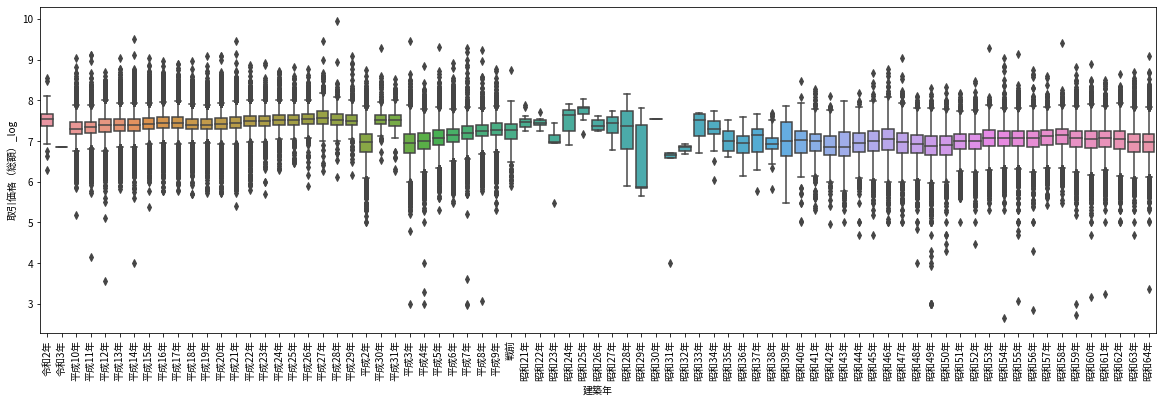

In [39]:
plt.figure(figsize=(20,6))
sns.boxplot(y=train_df['取引価格（総額）_log'],
            x=train_df["建築年"].sort_values())
plt.xticks(rotation=90)
plt.show()

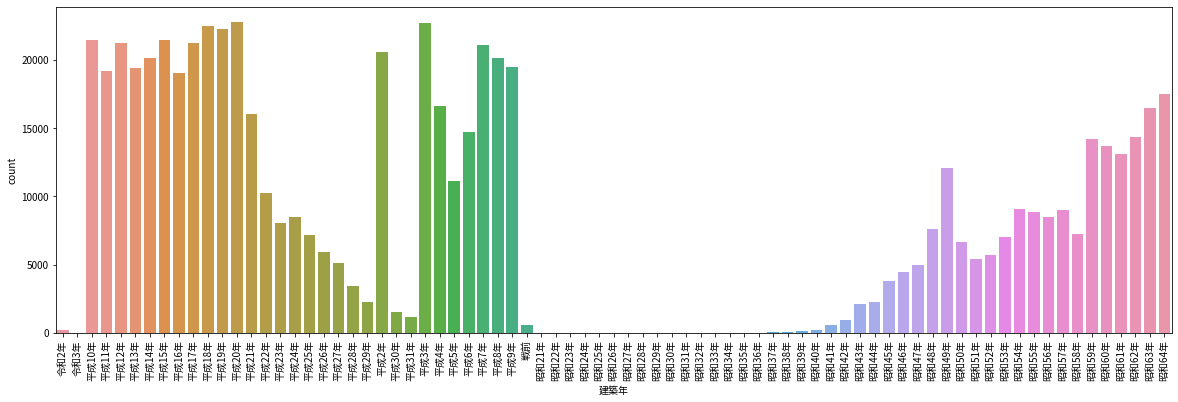

In [36]:
# ばらつきが小さい
plt.figure(figsize=(20,6))
sns.countplot(x=train_df["建築年"].sort_values())
plt.xticks(rotation=90)
plt.show()

# 取引時点

<AxesSubplot:xlabel='半期', ylabel='取引価格（総額）_log'>

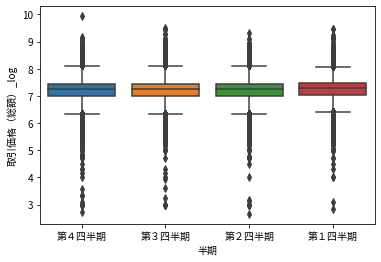

In [14]:
train_df["半期"] = train_df["取引時点"].str.split("年", expand=True)[1]
sns.boxplot(x=train_df["半期"], y=train_df["取引価格（総額）_log"])

In [18]:
train_df.groupby("半期").agg({"取引価格（総額）_log":["mean", "std", "max", "min", "var"]})

取引価格（総額）_log                                        
              mean       std       max       min       var
半期                                                        
第１四半期     7.235406  0.353090  9.462398  2.845098  0.124672
第２四半期     7.214526  0.354339  9.301030  2.653213  0.125556
第３四半期     7.218154  0.353343  9.505150  2.991226  0.124851
第４四半期     7.212901  0.356082  9.934498  2.724276  0.126795

# Blocks Test

In [54]:
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import re
from sklearn.preprocessing import LabelEncoder

def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori


# 面積情報の前処理関数
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area


# 西暦情報に変換する関数
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

def preprocess(input_df):
    output_df = input_df.copy()

    output_df['最寄駅：距離（分）'] = output_df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))
    output_df['面積（㎡）'] = output_df['面積（㎡）'].apply(lambda x: normalize_area(x))
    output_df['建築年'] = output_df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))

    # 建ぺい率と容積率を変換
    output_df["建ぺい率（％）"] = output_df["建ぺい率（％）"] / 100
    output_df["容積率（％）"] = output_df["容積率（％）"] / 100

    # 取引時点の年数を算出
    output_df["取引時点_年次"] = output_df["取引時点"].copy()
    output_df["取引時点"] = output_df['取引時点'].apply(lambda x: int(x[:4]))

    return output_df

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# test
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        raise NotImplementedError()

class ContinuousBlock(BaseBlock):
    def __init__(self, column):
        self.column = column

    def transform(self, input_df):
        return input_df[self.column].copy()


class CountEncodingBlock(BaseBlock):
    def __init__(self, column, whole_df: pd.DataFrame):
        self.column = column
        self.whole_df = whole_df

    def transform(self, input_df):
        output_df = pd.DataFrame()
        c = self.column

        vc = self.whole_df[c].value_counts()
        output_df[c] = input_df[c].map(vc)
        return output_df.add_prefix("CE_")


class OheHotEncodingBlock(BaseBlock):
    def __init__(self, column, count_limit: int):
        self.column = column
        self.count_limit = count_limit

    def fit(self, input_df, y=None):
        vc = input_df[self.column].dropna().value_counts()
        cats_ = vc[vc > self.count_limit].index
        self.cats_ = cats_
        return self.transform(input_df)

    def transform(self, input_df):
        x = pd.Categorical(input_df[self.column], categories=self.cats_)
        output_df = pd.get_dummies(x, dummy_na=False)
        output_df.columns = output_df.columns.to_list()
        return output_df.add_prefix(f'OHE_{self.column}=')


class LabelEncodingBlock(BaseBlock):
    def __init__(self, column: str, whole_df: pd.DataFrame):
        self.column = column
        self.le = LabelEncoder()
        self.whole_df = whole_df

    def fit(self, input_df, y=None):
        self.le.fit(self.whole_df[self.column].fillna("nan"))
        return self.transform(input_df)

    def transform(self, input_df):
        c = self.column
        output_df = input_df.copy()
        output_df[c] = self.le.transform(input_df[c].fillna("nan")).astype("int")
        output_df = output_df[[c]]
        return output_df.add_prefix(f"LE_")


class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function

    def transform(self, input_df):
        return self.function(input_df)


# 特定カラムの四則演算
class ArithmeticOperationBlock(BaseBlock):
    def __init__(self, target_column1: str, target_column2: str, operation: str):
        self.target_column1 = target_column1
        self.target_column2 = target_column2
        self.operation = operation

    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        output_df = input_df.copy()
        output_df_columns_name = f'{self.target_column1}{self.operation}{self.target_column2}'

        if self.operation == "+":
            output_df[output_df_columns_name] = output_df[self.target_column1] + output_df[self.target_column2]

        elif self.operation == "-":
            output_df[output_df_columns_name] = output_df[self.target_column1] - output_df[self.target_column2]

        elif self.operation == "*":
            output_df[output_df_columns_name] = output_df[self.target_column1] * output_df[self.target_column2]

        elif self.operation == "/":
            output_df[output_df_columns_name] = output_df[self.target_column1] / output_df[self.target_column2]

        return output_df[output_df_columns_name]


class AggregationBlock(BaseBlock):
    def __init__(self, whole_df: pd.DataFrame,
                 key: str,
                 agg_column: str,
                 agg_funcs: ["mean"],
                 fillna=None):
        self.whole_df = whole_df
        self.key = key
        self.agg_column = agg_column
        self.agg_funcs = agg_funcs
        self.fillna = fillna

    def fit(self, input_df):
        return self.transform(input_df)

    def transform(self, input_df):
        if self.fillna:
            self.whole_df[self.agg_column] = self.whole_df[self.agg_column].fillna(self.fillna)

        self.group_df = self.whole_df.groupby(self.key).agg({self.agg_column: self.agg_funcs}).reset_index()
        column_names = [f'GP_{self.agg_column}@{self.key}_{agg_func}' for agg_func in self.agg_funcs]

        self.group_df.columns = [self.key] + column_names
        output_df = pd.merge(input_df[self.key], self.group_df, on=self.key, how="left").drop(columns=[self.key])
        return output_df

class AgeBlock(BaseBlock):
    def __init__(self, column: str):
        self.column = column

    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        output_df = input_df.copy()
        output_df_col_name = f'Age@{self.column}'

        output_df[output_df_col_name] = 2021 - input_df[self.column]

        return output_df[output_df_col_name]


class TargetEncodingBlock(BaseBlock):
    def __init__(self, column:str, target_column:str, agg_funcs:str=['mean']):
        self.column = column
        self.target_column = target_column
        self.agg_funcs = agg_funcs

    def fit(self, input_df):
        self.target_map = input_df.groupby(self.column)[self.target_column].agg(self.agg_funcs)
        
        output_encoded = np.zeros((len(input_df), len(self.agg_funcs)))
        kf = KFold(n_splits=4, shuffle=True, random_state=1000)
        for index, agg_func in enumerate(self.agg_funcs):
            for train_idx, valid_idx in kf.split(input_df):
                target_map = input_df.iloc[train_idx].groupby(self.column)[self.target_column].agg(self.agg_funcs)
                output_encoded[valid_idx, index] = input_df.iloc[valid_idx][self.column].map(target_map[agg_func].to_dict())
        
        output_encoded = pd.DataFrame(output_encoded)
        output_encoded.columns = [f'TE_{self.column}_{self.target_column}_{agg_func}' for agg_func in self.agg_funcs]
        return output_encoded
    
    def transform(self, input_df):
        output_encoded = np.zeros((len(input_df), len(self.agg_funcs)))
        for index, agg_func in enumerate(self.agg_funcs):        
            output_encoded[:,index] = input_df[self.column].map(self.target_map['mean'].to_dict()).values
            
        output_encoded = pd.DataFrame(output_encoded)
        output_encoded.columns = [f'TE_{self.column}_{self.target_column}_{agg_func}' for agg_func in self.agg_funcs]
        return output_encoded

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)


def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)


def to_feature(input_df,
               blocks,
               is_train=False):
    out_df = pd.DataFrame()

    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)

        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
    return reduce_mem_usage(out_df)


In [55]:
# station block
class StationInfoBlock(BaseBlock):
    def __init__(self, columns:str):
        self.columns = columns
        
        
    def transform(self, input_df):
        output_df = pd.DataFrame()
        station_df = pd.read_csv("../add/station.csv").drop_duplicates("最寄駅：名称")
        _df = pd.merge(input_df, station_df, on="最寄駅：名称", how="left")
        
        c = self.columns

        vc = _df[c].value_counts()
        output_df[c] = _df[c].map(vc)
        return output_df.add_prefix("CE_")

In [56]:
class LandPriceBlock(BaseBlock):
    def __init__(self, column: str):
        self.column = column

    def transform(self, input_df):
        use_columns = [
            "所在地コード",
            "Ｒ３価格",
            "Ｒ２価格",
            "Ｈ３１価格",
            "Ｈ３０価格",
            "Ｈ２９価格",
            "Ｈ２８価格",
            "Ｈ２７価格",
            "Ｈ２６価格",
            "Ｈ２５価格",
            "Ｈ２４価格",
            "Ｈ２３価格",
            "Ｈ２２価格",
            "Ｈ２１価格",
            "Ｈ２０価格"]
        
        # メモリ節約のため、必要データのみ呼ぶ
        land_price_df = pd.read_csv("../add/landprice.csv", encoding="cp932", 
                                    usecols=use_columns).groupby("所在地コード").mean().reset_index()
        land_price_df.rename(columns={"所在地コード": "市区町村コード"}, inplace=True)

        c = self.column

        output_df = pd.merge(input_df, land_price_df, on="市区町村コード", how="left")

        return output_df[c]

In [57]:
class LandAggregationBlock(BaseBlock):
    def __init__(self, whole_df, key: str, agg_column: str, agg_funcs=["mean"], fillna=None):
        self.whole_df = whole_df
        self.key = key
        self.agg_column = agg_column
        self.agg_funcs = agg_funcs
        self.fillna = fillna
        
    def fit(self, input_df, y=None):
        land_price_df = pd.read_csv("../add/landprice.csv", encoding="cp932").groupby("所在地コード").mean().reset_index()
        land_price_df.rename(columns={"所在地コード":"市区町村コード"}, inplace=True)
        self.merge_df_ = pd.merge(self.whole_df, land_price_df, on="市区町村コード", how="left")
        
        return self.transform(input_df)
    
    def transform(self, input_df):
        if self.fillna:
            self.whole_df[self.agg_column] = self.whole_df[self.agg_column].fillna(self.fillna)
        
        self.group_df = self.merge_df_.groupby(self.key).agg({self.agg_column:self.agg_funcs}).reset_index()
        column_names = [f"LAND_GP_{self.agg_column}@{self.key}_{agg_func}" for agg_func in self.agg_funcs]
        
        self.group_df.columns = [self.key] + column_names
        output_df = pd.merge(input_df[self.key], self.group_df, on=self.key, how="left").drop(columns=[self.key])
        return output_df

In [58]:
train = preprocess(train_df)
test = preprocess(test_df)
whole_df = pd.concat([train, test],axis=0)

In [59]:
print(len(train))
print(len(pd.merge(train, pd.read_csv("../add/station.csv").drop_duplicates("最寄駅：名称"), on="最寄駅：名称", how="left")))

662799
662799


<AxesSubplot:xlabel='建築年'>

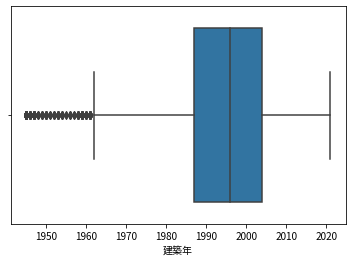

In [60]:
sns.boxplot(x=train["建築年"])

<AxesSubplot:xlabel='建築年'>

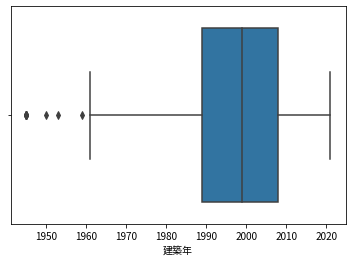

In [61]:
sns.boxplot(x=test["建築年"])

In [62]:
train

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_年次
0,8033256,中古マンション等,NaN,8203,茨城県,土浦市,川口,土浦,11.0,４ＬＤＫ,75,NaN,NaN,NaN,2006.0,ＲＣ,住宅,NaN,NaN,NaN,NaN,第２種住居地域,0.6,2.0,2009,未改装,NaN,7.255273,2009年第４四半期
1,8041376,中古マンション等,NaN,8220,茨城県,つくば市,並木,つくば,45.0,３ＬＤＫ,80,NaN,NaN,NaN,2008.0,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種中高層住居専用地域,0.6,2.0,2010,改装済,NaN,7.278754,2010年第３四半期
2,8003595,中古マンション等,NaN,8201,茨城県,水戸市,南町,水戸,13.0,１ＬＤＫ,70,NaN,NaN,NaN,NaN,ＳＲＣ,店舗,店舗,NaN,NaN,NaN,商業地域,0.8,4.0,2014,未改装,NaN,6.633468,2014年第４四半期
3,8000968,中古マンション等,NaN,8201,茨城県,水戸市,大町,水戸,16.0,２ＬＤＫ,60,NaN,NaN,NaN,2007.0,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,近隣商業地域,0.8,4.0,2019,未改装,NaN,7.204120,2019年第２四半期
4,8044248,中古マンション等,NaN,8220,茨城県,つくば市,並木,つくば,45.0,３ＬＤＫ,80,NaN,NaN,NaN,2008.0,ＲＣ,住宅,住宅,NaN,NaN,NaN,第１種中高層住居専用地域,0.6,2.0,2017,未改装,NaN,7.301030,2017年第１四半期
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662794,3005573,中古マンション等,NaN,3201,岩手県,盛岡市,東山,盛岡,45.0,２ＬＤＫ,65,NaN,NaN,NaN,1992.0,ＲＣ,住宅,住宅,NaN,NaN,NaN,第２種中高層住居専用地域,0.6,2.0,2017,改装済,NaN,6.949390,2017年第２四半期
662795,3005930,中古マンション等,NaN,3201,岩手県,盛岡市,茶畑,盛岡,45.0,２ＬＤＫ,70,NaN,NaN,NaN,1985.0,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種住居地域,0.6,2.0,2013,未改装,調停・競売等,6.799341,2013年第２四半期
662796,3015560,中古マンション等,NaN,3201,岩手県,盛岡市,材木町,盛岡,8.0,１Ｋ,70,NaN,NaN,NaN,1985.0,ＳＲＣ,店舗,NaN,NaN,NaN,NaN,商業地域,0.8,4.0,2009,未改装,調停・競売等,6.255273,2009年第２四半期
662797,3003542,中古マンション等,NaN,3201,岩手県,盛岡市,中央通,盛岡,8.0,２ＤＫ,40,NaN,NaN,NaN,1984.0,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,0.8,4.0,2017,未改装,NaN,6.812913,2017年第３四半期


In [16]:
train.groupby("最寄駅：距離（分）").mean()

,ID,地域,市区町村コード,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,建ぺい率（％）,容積率（％）,取引時点,取引価格（総額）_log
最寄駅：距離（分）,,,,,,,,,,,,,,,
0.0,1.820265e+07,NaN,18246.560166,54.784751,NaN,NaN,NaN,1995.639153,NaN,NaN,NaN,0.784667,4.970773,2013.212915,7.309720
1.0,1.810276e+07,NaN,18142.230956,54.636151,NaN,NaN,NaN,1997.631448,NaN,NaN,NaN,0.766826,4.403690,2013.528602,7.319250
2.0,1.792012e+07,NaN,17954.696190,51.254194,NaN,NaN,NaN,1996.957417,NaN,NaN,NaN,0.755797,4.189439,2013.709079,7.290342
3.0,1.833742e+07,NaN,18374.045005,52.953790,NaN,NaN,NaN,1996.736558,NaN,NaN,NaN,0.741047,3.944410,2013.624902,7.287793
4.0,1.807641e+07,NaN,18111.458254,53.107687,NaN,NaN,NaN,1996.372180,NaN,NaN,NaN,0.725061,3.715231,2013.643874,7.276354
5.0,1.829339e+07,NaN,18327.357861,53.576505,NaN,NaN,NaN,1996.083229,NaN,NaN,NaN,0.711591,3.508947,2013.703554,7.266076
6.0,1.826324e+07,NaN,18297.109300,54.986043,NaN,NaN,NaN,1996.421898,NaN,NaN,NaN,0.694701,3.278795,2013.519229,7.269745
7.0,1.809085e+07,NaN,18117.756158,54.605158,NaN,NaN,NaN,1995.777835,NaN,NaN,NaN,0.684646,3.151549,2013.692989,7.263506
8.0,1.816434e+07,NaN,18194.911869,57.099132,NaN,NaN,NaN,1995.656061,NaN,NaN,NaN,0.671298,2.942926,2013.539053,7.250800


In [50]:
pd.merge(train_df[["ID","取引時点"]],train_df.groupby("取引時点")["取引価格（総額）_log"].mean().diff().reset_index(), on="取引時点", how="left")

,ID,取引時点,取引価格（総額）_log
0,8033256,2009年第４四半期,-0.008927
1,8041376,2010年第３四半期,0.024181
2,8003595,2014年第４四半期,0.002846
3,8000968,2019年第２四半期,-0.008421
4,8044248,2017年第１四半期,0.014110
...,...,...,...
662794,3005573,2017年第２四半期,-0.006357
662795,3005930,2013年第２四半期,0.003489
662796,3015560,2009年第２四半期,-0.018361
662797,3003542,2017年第３四半期,0.009850


In [52]:
train_df.groupby("取引時点")["取引価格（総額）_log"].mean().diff(2).reset_index()

,取引時点,取引価格（総額）_log
0,2005年第３四半期,NaN
1,2005年第４四半期,NaN
2,2006年第１四半期,0.044685
3,2006年第２四半期,-0.065651
4,2006年第３四半期,-0.074948
5,2006年第４四半期,0.020228
6,2007年第１四半期,0.029685
7,2007年第２四半期,-0.018451
8,2007年第３四半期,-0.045948
9,2007年第４四半期,0.005722


In [65]:
def get_diff_price(input_df):
    use_columns = ["取引時点", "取引価格（総額）_log"]
    price_df = pd.read_csv("../input/train.csv", usecols=use_columns).groupby("取引時点")["取引価格（総額）_log"].mean().diff(2).reset_index()
    price_df.rename(columns={"取引時点":"取引時点_年次",
                             "取引価格（総額）_log":"price_diff"}, inplace=True)
    
    output_df = pd.merge(input_df, price_df, on="取引時点_年次", how="left")
    
    c = "price_diff"
    
    return output_df[c]

In [66]:
get_diff_price(train)

0        -0.000027
1        -0.001909
2         0.015474
3         0.010607
4         0.006618
            ...   
662794    0.007754
662795    0.024031
662796    0.006998
662797    0.003493
662798    0.004402
Name: price_diff, Length: 662799, dtype: float64

In [40]:
# これだと、取引時点の情報がずれる？
class DiffBlock(BaseBlock):
    def __init__(self, key: str, target_column: str, diff: int):
        self.key = key
        self.target_column = target_column
        self.diff = diff

    def fit(self, input_df):
        return self.transform(input_df)

    def transform(self, input_df):
        output_df = input_df.copy()
        output_df[self.key] = output_df[self.key].fillna("nan")
        output_df[f'Diff{self.diff}_{self.target_column}@{self.key}'] = \
            output_df.groupby(self.key)[self.target_column].transform(lambda x:x.diff(self.diff))

        return output_df[f'Diff{self.diff}_{self.target_column}@{self.key}']

In [45]:
from sklearn.model_selection import KFold


process_blocks=[DiffBlock(key="取引時点", target_column="取引価格（総額）_log", diff=1)]


train_x = to_feature(train, process_blocks, is_train=True)
test_x = to_feature(test, process_blocks)

  0%|          | 0/1 [00:00<?, ?it/s]

create <__main__.DiffBlock object at 0x7f46097d59e8> 0.106[s]
Memory usage of dataframe is 10.11 MB
Memory usage after optimization is: 6.32 MB
Decreased by 37.5%


KeyError: 'Column not found: 取引価格（総額）_log'

In [43]:
train_x

,Diff1_建ぺい率（％）@取引時点
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
662794,0.000000
662795,-0.199951
662796,0.000000
662797,0.199951


In [32]:
land_price_df = pd.read_csv("../add/landprice.csv", encoding="cp932")

In [33]:
land_price_df

,経度,緯度,所在地コード,用途,連番,年次,前年所在地コード,前年用途,前年連番,市区町村名,住居表示,行政,地積,利用の現況,利用状況表示,建物構造,施設,形状区分,間口（比率）,奥行（比率）,階層（地上）,階層（地下）,前面道路区分,前面道路の方位区分,前面道路の幅員,前面道路の駅前区分,前面道路の舗装状況,側道区分,側道方位区分,交通施設との近接区分,周辺の土地の利用の現況,駅名,駅距離,用途区分,防火区分,都市計画区分,森林区分,公園区分,建蔽率,容積率,共通地点区分,選定年次ビット,Ｓ５８価格,Ｓ５９価格,Ｓ６０価格,Ｓ６１価格,Ｓ６２価格,Ｓ６３価格,Ｈ１価格,Ｈ２価格,...,Ｈ２２価格,Ｈ２３価格,Ｈ２４価格,Ｈ２５価格,Ｈ２６価格,Ｈ２７価格,Ｈ２８価格,Ｈ２９価格,Ｈ３０価格,Ｈ３１価格,Ｒ２価格,Ｒ３価格,属性移動Ｓ５９,属性移動Ｓ６０,属性移動Ｓ６１,属性移動Ｓ６２,属性移動Ｓ６３,属性移動Ｈ１,属性移動Ｈ２,属性移動Ｈ３,属性移動Ｈ４,属性移動Ｈ５,属性移動Ｈ６,属性移動Ｈ７,属性移動Ｈ８,属性移動Ｈ９,属性移動Ｈ１０,属性移動Ｈ１１,属性移動Ｈ１２,属性移動Ｈ１３,属性移動Ｈ１４,属性移動Ｈ１５,属性移動Ｈ１６,属性移動Ｈ１７,属性移動Ｈ１８,属性移動Ｈ１９,属性移動Ｈ２０,属性移動Ｈ２１,属性移動Ｈ２２,属性移動Ｈ２３,属性移動Ｈ２４,属性移動Ｈ２５,属性移動Ｈ２６,属性移動Ｈ２７,属性移動Ｈ２８,属性移動Ｈ２９,属性移動Ｈ３０,属性移動Ｈ３１,属性移動Ｒ２,属性移動Ｒ３
0,508730.562,154999.616,1101,0,1,2021,1101,0,1,札幌中央,北海道 札幌市中央区大通西２８－２－５,1101,495,10000000000000000,_,RC2F1B,111,台形,10,20,2,1,市道,東,109,_,_,_,_,_,大規模住宅、領事館等が存する閑静な住宅地域,円山公園,200,1中専,_,市街化,_,_,60,200,False,111111111111111111111111111111111111111,126000,133000,140000,146000,152000,182000,275000,390000,...,200000,195000,195000,200000,213000,227000,263000,287000,310000,340000,373000,384000,10001000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,11000000000000,10000000000000,10000000000000,10000010000000,10000001000011,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000
1,508821.829,154950.512,1101,0,2,2021,1101,0,2,札幌中央,北海道 札幌市中央区南１３条西１３－２－１０,1101,162,10000000000000000,_,W2F1B,111,_,10,15,2,1,市道,南,54,_,_,_,_,_,一般住宅、アパート等が建ち並ぶ既成住宅地域,西１１丁目,2100,1住居,_,市街化,_,_,60,200,False,000000000000001111111111111111111111111,0,0,0,0,0,0,0,0,...,105000,101000,99000,99000,104000,109000,121000,128000,133000,139000,151000,157000,0,0,0,0,0,0,0,0,0,0,0,0,0,40000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000010000010,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000
2,508840.405,154969.668,1101,0,3,2021,1101,0,3,札幌中央,北海道 札幌市中央区南１０条西９－１－４８,1101,172,10000000000000100,共同住宅,W2F1B,111,_,10,20,2,1,市道,北,54,_,_,_,_,_,アパート、マンション等が密集する住宅地域,中島公園,1000,1住居,_,市街化,_,_,60,200,False,111111111111111111111111111111111111111,110000,116000,122000,127000,132000,145000,200000,283000,...,104000,100000,98000,98000,101000,103000,115000,120000,125000,131000,143000,148000,10001000000000,10000000000000,10000000000000,10000000000000,11000000000000,10000000000000,10000000000000,10010000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000001000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000010,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000
3,508857.995,154930.896,1101,0,4,2021,1101,0,4,札幌中央,北海道 札幌市中央区南１８条西８－１－４３,1101,146,10000000000000000,_,W2F1B,111,_,10,20,2,1,市道,北,109,_,_,_,_,_,一般住宅、マンション等が建ち並ぶ既成住宅地域,幌平橋,800,1住居,_,市街化,_,_,60,200,True,000000000000001111111111111111111111111,0,0,0,0,0,0,0,0,...,105000,101000,99000,99000,103000,107000,119000,129000,135000,144000,162000,171000,0,0,0,0,0,0,0,0,0,0,0,0,0,40000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000010,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,100000000

In [26]:
train

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,8033256,中古マンション等,NaN,8203,茨城県,土浦市,川口,土浦,11.0,４ＬＤＫ,75,NaN,NaN,NaN,2006.0,ＲＣ,住宅,NaN,NaN,NaN,NaN,第２種住居地域,0.6,2.0,2009,未改装,NaN,7.255273
1,8041376,中古マンション等,NaN,8220,茨城県,つくば市,並木,つくば,45.0,３ＬＤＫ,80,NaN,NaN,NaN,2008.0,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種中高層住居専用地域,0.6,2.0,2010,改装済,NaN,7.278754
2,8003595,中古マンション等,NaN,8201,茨城県,水戸市,南町,水戸,13.0,１ＬＤＫ,70,NaN,NaN,NaN,NaN,ＳＲＣ,店舗,店舗,NaN,NaN,NaN,商業地域,0.8,4.0,2014,未改装,NaN,6.633468
3,8000968,中古マンション等,NaN,8201,茨城県,水戸市,大町,水戸,16.0,２ＬＤＫ,60,NaN,NaN,NaN,2007.0,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,近隣商業地域,0.8,4.0,2019,未改装,NaN,7.204120
4,8044248,中古マンション等,NaN,8220,茨城県,つくば市,並木,つくば,45.0,３ＬＤＫ,80,NaN,NaN,NaN,2008.0,ＲＣ,住宅,住宅,NaN,NaN,NaN,第１種中高層住居専用地域,0.6,2.0,2017,未改装,NaN,7.301030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662794,3005573,中古マンション等,NaN,3201,岩手県,盛岡市,東山,盛岡,45.0,２ＬＤＫ,65,NaN,NaN,NaN,1992.0,ＲＣ,住宅,住宅,NaN,NaN,NaN,第２種中高層住居専用地域,0.6,2.0,2017,改装済,NaN,6.949390
662795,3005930,中古マンション等,NaN,3201,岩手県,盛岡市,茶畑,盛岡,45.0,２ＬＤＫ,70,NaN,NaN,NaN,1985.0,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種住居地域,0.6,2.0,2013,未改装,調停・競売等,6.799341
662796,3015560,中古マンション等,NaN,3201,岩手県,盛岡市,材木町,盛岡,8.0,１Ｋ,70,NaN,NaN,NaN,1985.0,ＳＲＣ,店舗,NaN,NaN,NaN,NaN,商業地域,0.8,4.0,2009,未改装,調停・競売等,6.255273
662797,3003542,中古マンション等,NaN,3201,岩手県,盛岡市,中央通,盛岡,8.0,２ＤＫ,40,NaN,NaN,NaN,1984.0,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,0.8,4.0,2017,未改装,NaN,6.812913


In [27]:
train["今後の利用目的"].value_counts()

住宅     277897
その他     16983
事務所      3309
店舗       1138
Name: 今後の利用目的, dtype: int64

In [28]:
train["建物の構造"].value_counts()

ＲＣ            448093
ＳＲＣ           193381
鉄骨造             4417
ＳＲＣ、ＲＣ           707
ＲＣ、鉄骨造           329
ＳＲＣ、鉄骨造          148
木造                85
ブロック造             22
軽量鉄骨造             18
ＳＲＣ、ＲＣ、鉄骨造         2
ＲＣ、ブロック造           1
ＲＣ、木造              1
Name: 建物の構造, dtype: int64

In [29]:
train["間取り"].value_counts()

３ＬＤＫ     282623
１Ｋ        96505
２ＬＤＫ      95428
４ＬＤＫ      60588
１ＬＤＫ      28060
          ...  
２Ｌ＋Ｓ          1
４Ｄ            1
１Ｌ＋Ｓ          1
７ＤＫ           1
１ＤＫ＋Ｋ         1
Name: 間取り, Length: 63, dtype: int64

In [30]:
train["都市計画"].value_counts()

商業地域                      180135
第１種中高層住居専用地域              103293
第１種住居地域                   101317
準工業地域                      75592
近隣商業地域                     66666
第２種中高層住居専用地域               30520
第２種住居地域                    30514
第１種低層住居専用地域                20161
工業地域                       16578
準住居地域                      13175
市街化調整区域                     4173
第２種低層住居専用地域                  906
市街化区域及び市街化調整区域外の都市計画区域       313
工業専用地域                       230
都市計画区域外                      222
準都市計画区域                        7
Name: 都市計画, dtype: int64